In [18]:
# Mobile bert
!pip install transformers datasets torch pandas numpy seqeval
!pip install tensorflow
! pip install tf-keras
! pip install transformers[torch]



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## MobileBERT Fine-tuning para Detección de Productos Cosméticos y Atributos

In [19]:
# DEPENDENCIAS
import pandas as pd
import numpy as np
import torch
import os
import re
import json
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorForTokenClassification
)
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers.trainer_callback import EarlyStoppingCallback


In [20]:

# Configuración
RUTA_DATOS = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\data_bert\labeled_sentences.xlsx"
MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\products_attributes"
BATCH_SIZE = 9
LEARNING_RATE = 3e-5
NUM_EPOCHS = 9
MAX_LENGTH = 128
WARMUP_RATIO = 0.1   
SEED = 6
TRAIN_TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.5  # Del conjunto de test, la mitad será para validación

# Configuración de etiquetas
# Usaremos esquema BIO (Beginning, Inside, Outside) para entidades
# B-PRODUCT: Inicio de producto
# I-PRODUCT: Continuación de producto
# B-ATTRIBUTE: Inicio de atributo
# I-ATTRIBUTE: Continuación de atributo
# O: No es parte de una entidad

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [21]:
# 1. Carga de datos etiquetados
print("Cargando datos etiquetados...")
try:
    df = pd.read_excel(RUTA_DATOS)
    print(f"Datos cargados correctamente. Total de filas: {len(df)}")
    print(f"Columnas disponibles: {', '.join(df.columns)}")
    print(df.head())
except Exception as e:
    print(f"Error al cargar los datos: {str(e)}")

print("\nPreprocesando datos...")

# Función para dividir texto en tokens a nivel de palabra
def simple_tokenize(text):
    """Tokeniza un texto en palabras."""
    # Manejar NaN o valores vacíos
    if pd.isna(text) or text == "":
        return []
    # Tokenización simple por espacios y puntuación
    tokens = re.findall(r'\b\w+\b|[^\w\s]', text)
    return tokens

# Función para convertir etiquetas de productos y atributos a formato BIO
def create_bio_tags(text, products, attributes):
    """
    Crea etiquetas BIO para un texto dado productos y atributos.
    
    Args:
        text (str): Texto original
        products (str): Lista de productos separados por comas
        attributes (str): Lista de atributos separados por comas
        
    Returns:
        list: Lista de etiquetas BIO alineadas con tokens del texto
    """
    tokens = simple_tokenize(text)
    if not tokens:
        return []
    
    # Inicializar todas las etiquetas como "O" (Outside)
    bio_tags = ["O"] * len(tokens)
    
    # Procesar productos
    if not pd.isna(products) and products.strip() != "":
        product_list = [p.strip().lower() for p in products.split(',')]
        for product in product_list:
            # Extraer el nombre del producto sin la categoría entre paréntesis
            match = re.match(r"(.*?)(\s*\(.*\))?$", product)
            if match:
                product_name = match.group(1).strip().lower()
                product_tokens = simple_tokenize(product_name)
                
                if product_tokens:
                    # Buscar el producto en el texto tokenizado
                    for i in range(len(tokens) - len(product_tokens) + 1):
                        if [t.lower() for t in tokens[i:i+len(product_tokens)]] == [t.lower() for t in product_tokens]:
                            # Marcar el primer token como B-PRODUCT
                            bio_tags[i] = "B-PRODUCT"
                            # Marcar los tokens restantes como I-PRODUCT
                            for j in range(1, len(product_tokens)):
                                bio_tags[i + j] = "I-PRODUCT"
    
    # Procesar atributos
    if not pd.isna(attributes) and attributes.strip() != "":
        attribute_list = [a.strip().lower() for a in attributes.split(',')]
        for attribute in attribute_list:
            attribute_tokens = simple_tokenize(attribute)
            
            if attribute_tokens:
                # Buscar el atributo en el texto tokenizado
                for i in range(len(tokens) - len(attribute_tokens) + 1):
                    if [t.lower() for t in tokens[i:i+len(attribute_tokens)]] == [t.lower() for t in attribute_tokens]:
                        # Marcar el primer token como B-ATTRIBUTE
                        bio_tags[i] = "B-ATTRIBUTE"
                        # Marcar los tokens restantes como I-ATTRIBUTE
                        for j in range(1, len(attribute_tokens)):
                            bio_tags[i + j] = "I-ATTRIBUTE"
    
    return list(zip(tokens, bio_tags))

Cargando datos etiquetados...
Datos cargados correctamente. Total de filas: 489
Columnas disponibles: id_urlvideo, transcription, products_detected, attributes_detected
                                         id_urlvideo  \
0  https://www.tiktok.com/@scurtoworld/video/6868...   
1  https://www.tiktok.com/@missprettygirl/video/7...   
2  https://www.tiktok.com/@mariane.liebhaber/vide...   
3  https://www.tiktok.com/@fake.it.tilu.make.it/v...   
4  https://www.tiktok.com/@hunterdestin/video/745...   

                                       transcription  \
0  No shadow for me today, but we're gonna have t...   
1  Looks like a brown liner and then like a pink ...   
2        Next thing are these touch land power mist.   
3  And I upgraded to the glass bottles, not the b...   
4      So we'll kind of like mix these two together.   

                                 products_detected      attributes_detected  
0                                eyeliner (makeup)                      NaN  
1

In [22]:
# Aplicar el procesamiento a nuestros datos
tokenized_data = []
skipped_rows = 0

for i, row in tqdm(df.iterrows(), total=len(df), desc="Creando etiquetas BIO"):
    try:
        text = row['transcription']
        products = row['products_detected'] if 'products_detected' in row else ""
        attributes = row['attributes_detected'] if 'attributes_detected' in row else ""
        
        if pd.isna(text) or text.strip() == "":
            skipped_rows += 1
            continue
            
        token_tag_pairs = create_bio_tags(text, products, attributes)
        
        if token_tag_pairs:
            tokenized_data.append({
                'id': i,
                'tokens': [pair[0] for pair in token_tag_pairs],
                'bio_tags': [pair[1] for pair in token_tag_pairs],
                'text': text,
                'products': products if not pd.isna(products) else "",
                'attributes': attributes if not pd.isna(attributes) else ""
            })
        else:
            skipped_rows += 1
    except Exception as e:
        print(f"Error en la fila {i}: {str(e)}")
        skipped_rows += 1

print(f"Procesamiento completado. Datos tokenizados: {len(tokenized_data)}. Filas omitidas: {skipped_rows}")

Creando etiquetas BIO:   0%|          | 0/489 [00:00<?, ?it/s]

Procesamiento completado. Datos tokenizados: 489. Filas omitidas: 0


In [23]:
# Revisar estadísticas de etiquetas
all_tags = [tag for item in tokenized_data for tag in item['bio_tags']]
tag_counts = {tag: all_tags.count(tag) for tag in set(all_tags)}
print("\nDistribución de etiquetas:")
for tag, count in tag_counts.items():
    print(f"{tag}: {count} ({count/len(all_tags)*100:.2f}%)")


Distribución de etiquetas:
I-ATTRIBUTE: 202 (2.63%)
I-PRODUCT: 114 (1.48%)
B-ATTRIBUTE: 380 (4.94%)
O: 6638 (86.26%)
B-PRODUCT: 361 (4.69%)


### Distribución de Etiquetas:
- **O (Outside)**: 94.93%  
- **B-PRODUCT (Inicio de productos)**: 1.88%  
- **I-PRODUCT (Continuación de productos)**: 0.38%  
- **B-ATTRIBUTE (Inicio de atributos)**: 2.27%  
- **I-ATTRIBUTE (Continuación de atributos)**: 0.55%  

Este tipo de desequilibrio es bastante común en tareas de Named Entity Recognition (NER) porque la mayoría de las palabras en un texto no suelen ser entidades nombradas. Sin embargo, podría afectar el rendimiento del modelo, ya que hay pocas muestras de las clases minoritarias.  

#### Para Abordar el Desequilibrio:

- Sobremuestreo de Clases Minoritarias: Etiquetar más ejemplos que contengan productos y atributos para aumentar su representación en los datos de entrenamiento.  
-  Ajustar los Pesos de las Clases: Se puede modificar el código para dar más peso a las clases minoritarias durante el entrenamiento:  
```python
# En la definición de TrainingArguments
class_weights = torch.tensor([1.0, 20.0, 30.0, 20.0, 30.0])  # Ajustar estos valores según necesidades
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
```
- Regularización Más Fuerte: Para evitar que el modelo simplemente prediga "O" para todo, se puede aumentar la penalización por sobreajuste:  
```python
training_args = TrainingArguments(
    # Otros parámetros...
    weight_decay=0.1  # Aumentar el valor original (por ejemplo, de 0.01 a 0.1)
)
```
- Técnicas de Data Augmentation: Generar más ejemplos sintéticos para aumentar la representación de productos y atributos en el conjunto de entrenamiento.  
- Ajustar el Número de Épocas: Considerar aumentar el número de épocas de entrenamiento para que el modelo tenga más oportunidades de aprender los patrones menos frecuentes.  


In [24]:
# 3. Dividir en conjuntos de entrenamiento, validación y prueba
print("\nDividiendo datos en conjuntos de entrenamiento, validación y prueba...")

train_data, test_data = train_test_split(
    tokenized_data, 
    test_size=TRAIN_TEST_SPLIT_RATIO, 
    random_state=SEED
)

val_data, test_data = train_test_split(
    test_data, 
    test_size=VALIDATION_SPLIT_RATIO, 
    random_state=SEED
)

print(f"Conjunto de entrenamiento: {len(train_data)} ejemplos")
print(f"Conjunto de validación: {len(val_data)} ejemplos")
print(f"Conjunto de prueba: {len(test_data)} ejemplos")


Dividiendo datos en conjuntos de entrenamiento, validación y prueba...
Conjunto de entrenamiento: 391 ejemplos
Conjunto de validación: 49 ejemplos
Conjunto de prueba: 49 ejemplos


In [25]:
# 4. Preparación para MobileBERT
print("\nPreparando datos para MobileBERT...")

# Cargar tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Definir mapeo de etiquetas a IDs
unique_tags = sorted(list(set(all_tags)))
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

# Guardar el mapeo para uso futuro
with open(os.path.join(OUTPUT_DIR, 'tag_mapping.json'), 'w') as f:
    json.dump({'tag2id': tag2id, 'id2tag': id2tag}, f)

print(f"Mapeo de etiquetas: {tag2id}")

# Clase para tokenizar y preparar los datos para MobileBERT
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item['tokens']
        bio_tags = item['bio_tags']
        
        # Tokenizar palabras usando el tokenizador de MobileBERT
        word_ids = []
        input_ids = []
        attention_mask = []
        labels = []
        
        # Añadir token [CLS] al inicio
        input_ids.append(tokenizer.cls_token_id)
        attention_mask.append(1)
        word_ids.append(None)
        labels.append(-100)  # -100 es ignorado en la función de pérdida
        
        # Tokenizar cada palabra y alinear con etiquetas BIO
        for word_idx, (word, tag) in enumerate(zip(tokens, bio_tags)):
            # Tokenizar la palabra (podría dar múltiples tokens)
            word_tokens = tokenizer.tokenize(word)
            if not word_tokens:
                # Si la palabra está fuera del vocabulario o es ignorada, usamos el token desconocido
                word_tokens = [tokenizer.unk_token]
                
            # Añadir IDs de tokens
            for i, _ in enumerate(word_tokens):
                input_ids.append(tokenizer.convert_tokens_to_ids(word_tokens[i]))
                attention_mask.append(1)
                word_ids.append(word_idx)
                
                # Solo el primer subtoken mantiene la etiqueta, el resto se ignora
                if i == 0:
                    labels.append(tag2id[tag])
                else:
                    labels.append(-100)
        
        # Añadir token [SEP] al final
        input_ids.append(tokenizer.sep_token_id)
        attention_mask.append(1)
        word_ids.append(None)
        labels.append(-100)
        
        # Rellenar o truncar a max_length
        padding_length = self.max_length - len(input_ids)
        
        if padding_length > 0:
            # Rellenar
            input_ids.extend([tokenizer.pad_token_id] * padding_length)
            attention_mask.extend([0] * padding_length)
            labels.extend([-100] * padding_length)
            word_ids.extend([None] * padding_length)
        elif padding_length < 0:
            # Truncar
            input_ids = input_ids[:self.max_length]
            attention_mask = attention_mask[:self.max_length]
            labels = labels[:self.max_length]
            word_ids = word_ids[:self.max_length]
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
            'word_ids': word_ids  # Esto es para debugging, no se usa en entrenamiento
        }


Preparando datos para MobileBERT...
Mapeo de etiquetas: {'B-ATTRIBUTE': 0, 'B-PRODUCT': 1, 'I-ATTRIBUTE': 2, 'I-PRODUCT': 3, 'O': 4}


In [26]:
# Crear conjuntos de datos
train_dataset = NERDataset(train_data, tokenizer, MAX_LENGTH)
val_dataset = NERDataset(val_data, tokenizer, MAX_LENGTH)
test_dataset = NERDataset(test_data, tokenizer, MAX_LENGTH)

# 5. Configurar y entrenar el modelo
print("\nConfigurando y entrenando el modelo MobileBERT...")

# Aumentar significativamente los pesos para las clases minoritarias
total_labels = 5450 + 169 + 132 + 44 + 28  # Total de todas las etiquetas

# Opción más agresiva para los pesos
class_weights = [
    0.3,                         # O (casi ignorado)
    total_labels / 143 * 3.0,     # B-PRODUCT (peso extremadamente alto)
    total_labels / 28 * 3.0,     # I-PRODUCT (peso extremadamente alto)
    total_labels / 194 * 9.0,     # B-ATTRIBUTE (peso extremadamente alto)
    total_labels / 38 * 9.0      # I-ATTRIBUTE (peso extremadamente alto)
]
# Limitar los pesos máximos, pero permitir valores más altos
class_weights = [min(weight, 50.0) for weight in class_weights]

# Cargar modelo base
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(unique_tags),
    id2label=id2tag,
    label2id=tag2id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.03,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",  # Cambiado a F1 para enfocarse en clases minoritarias
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir=os.path.join(OUTPUT_DIR, 'logs'),
)
from transformers.trainer_callback import EarlyStoppingCallback

# Definir data collator personalizado con pesos de clase
class WeightedDataCollator(DataCollatorForTokenClassification):
    def __init__(self, tokenizer, class_weights, label_name="labels"):
        super().__init__(tokenizer=tokenizer)
        self.class_weights = torch.tensor(class_weights)
        self.label_name = label_name

    def __call__(self, features):
        batch = super().__call__(features)
        return batch

# Métrica personalizada para evaluación que incluye F1
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=2)
    
    # Eliminar tokens especiales y padding
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Calcular métricas usando seqeval
    report = classification_report(true_labels, true_predictions, output_dict=True)
    
    # Formatear para el trainer
    results = {
        'accuracy': report['micro avg']['precision'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score']
    }
    
    # Añadir métricas por clase
    for key in report:
        if key not in ['macro avg', 'micro avg', 'weighted avg']:
            results[f"{key}_f1"] = report[key]['f1-score']
    
    return results

# Inicializar trainer con loss_fct personalizado
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Tensor de pesos
        weight = torch.tensor(class_weights, device=logits.device)
        
        # Calcular probabilidades
        probs = torch.nn.functional.softmax(logits, dim=-1)
        logits_view = logits.view(-1, model.config.num_labels)
        labels_view = labels.view(-1)
        
        # Seleccionar probabilidades para las clases correctas
        mask = labels_view != -100
        valid_labels = labels_view[mask]
        valid_logits = logits_view[mask]
        
        # Focal loss manual
        gamma = 1.5
        ce_loss = torch.nn.CrossEntropyLoss(weight=weight, reduction='none')
        ce = ce_loss(valid_logits, valid_labels)
        
        pt = torch.exp(-ce)
        focal_loss = ((1 - pt) ** gamma) * ce
        
        return (focal_loss.mean(), outputs) if return_outputs else focal_loss.mean()

# Usar el CustomTrainer en lugar del Trainer estándar
# Inicializar trainer con loss_fct personalizado
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)


Configurando y entrenando el modelo MobileBERT...


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\sandr\anaconda3\envs\MachineLearning\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\sandr\AppData\Local\Temp\ipykernel_12088\2872197540.py:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [27]:
# Métrica personalizada para evaluación
def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, axis=2)
    
    # Eliminar tokens especiales y padding
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Calcular métricas usando seqeval
    report = classification_report(true_labels, true_predictions, output_dict=True)
    
    # Formatear para el trainer
    results = {
        'accuracy': report['micro avg']['precision'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score']
    }
    
    # Añadir métricas por clase
    for key in report:
        if key not in ['macro avg', 'micro avg', 'weighted avg']:
            results[f"{key}_f1"] = report[key]['f1-score']
            results[f"{key}_precision"] = report[key]['precision']
            results[f"{key}_recall"] = report[key]['recall']
    
    return results

# Inicializar el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

# Entrenar el modelo
print("Comenzando entrenamiento...")
trainer.train()

# Guardar el modelo final
trainer.save_model(os.path.join(OUTPUT_DIR, 'final_model'))
print(f"Modelo guardado en: {os.path.join(OUTPUT_DIR, 'final_model')}")

# 6. Evaluación final
print("\nEvaluando el modelo en el conjunto de prueba...")
results = trainer.evaluate(test_dataset)

# Guardar resultados
with open(os.path.join(OUTPUT_DIR, 'evaluation_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print("\nResultados de evaluación:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

C:\Users\sandr\AppData\Local\Temp\ipykernel_12088\3984830881.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Comenzando entrenamiento...


  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3114899694919586, 'eval_accuracy': 0.417910447761194, 'eval_precision': 0.3819047619047619, 'eval_recall': 0.358678955453149, 'eval_f1': 0.36904761904761907, 'eval_ATTRIBUTE_f1': 0.21428571428571427, 'eval_ATTRIBUTE_precision': 0.24, 'eval_ATTRIBUTE_recall': 0.1935483870967742, 'eval_PRODUCT_f1': 0.5238095238095238, 'eval_PRODUCT_precision': 0.5238095238095238, 'eval_PRODUCT_recall': 0.5238095238095238, 'eval_runtime': 2.9585, 'eval_samples_per_second': 16.563, 'eval_steps_per_second': 2.028, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.21792076528072357, 'eval_accuracy': 0.5633802816901409, 'eval_precision': 0.5399193548387097, 'eval_recall': 0.5226574500768049, 'eval_f1': 0.5310778914240756, 'eval_ATTRIBUTE_f1': 0.35483870967741943, 'eval_ATTRIBUTE_precision': 0.3548387096774194, 'eval_ATTRIBUTE_recall': 0.3548387096774194, 'eval_PRODUCT_f1': 0.7073170731707318, 'eval_PRODUCT_precision': 0.725, 'eval_PRODUCT_recall': 0.6904761904761905, 'eval_runtime': 3.2509, 'eval_samples_per_second': 15.073, 'eval_steps_per_second': 1.846, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.20430731773376465, 'eval_accuracy': 0.573170731707317, 'eval_precision': 0.562015503875969, 'eval_recall': 0.6144393241167435, 'eval_f1': 0.5857142857142857, 'eval_ATTRIBUTE_f1': 0.3714285714285714, 'eval_ATTRIBUTE_precision': 0.3333333333333333, 'eval_ATTRIBUTE_recall': 0.41935483870967744, 'eval_PRODUCT_f1': 0.8, 'eval_PRODUCT_precision': 0.7906976744186046, 'eval_PRODUCT_recall': 0.8095238095238095, 'eval_runtime': 3.3366, 'eval_samples_per_second': 14.686, 'eval_steps_per_second': 1.798, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2287573516368866, 'eval_accuracy': 0.5949367088607594, 'eval_precision': 0.6188630490956072, 'eval_recall': 0.6228878648233487, 'eval_f1': 0.612959112959113, 'eval_ATTRIBUTE_f1': 0.4054054054054055, 'eval_ATTRIBUTE_precision': 0.3488372093023256, 'eval_ATTRIBUTE_recall': 0.4838709677419355, 'eval_PRODUCT_f1': 0.8205128205128205, 'eval_PRODUCT_precision': 0.8888888888888888, 'eval_PRODUCT_recall': 0.7619047619047619, 'eval_runtime': 3.2092, 'eval_samples_per_second': 15.269, 'eval_steps_per_second': 1.87, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.23773092031478882, 'eval_accuracy': 0.6025641025641025, 'eval_precision': 0.625, 'eval_recall': 0.618663594470046, 'eval_f1': 0.6148577449947312, 'eval_ATTRIBUTE_f1': 0.3835616438356164, 'eval_ATTRIBUTE_precision': 0.3333333333333333, 'eval_ATTRIBUTE_recall': 0.45161290322580644, 'eval_PRODUCT_f1': 0.8461538461538461, 'eval_PRODUCT_precision': 0.9166666666666666, 'eval_PRODUCT_recall': 0.7857142857142857, 'eval_runtime': 3.0671, 'eval_samples_per_second': 15.976, 'eval_steps_per_second': 1.956, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2715701758861542, 'eval_accuracy': 0.703125, 'eval_precision': 0.6581581581581581, 'eval_recall': 0.5779569892473119, 'eval_f1': 0.6154517677869926, 'eval_ATTRIBUTE_f1': 0.3448275862068965, 'eval_ATTRIBUTE_precision': 0.37037037037037035, 'eval_ATTRIBUTE_recall': 0.3225806451612903, 'eval_PRODUCT_f1': 0.8860759493670887, 'eval_PRODUCT_precision': 0.9459459459459459, 'eval_PRODUCT_recall': 0.8333333333333334, 'eval_runtime': 6.6943, 'eval_samples_per_second': 7.32, 'eval_steps_per_second': 0.896, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2751080393791199, 'eval_accuracy': 0.5833333333333334, 'eval_precision': 0.5833333333333334, 'eval_recall': 0.6424731182795699, 'eval_f1': 0.6084474885844748, 'eval_ATTRIBUTE_f1': 0.3835616438356164, 'eval_ATTRIBUTE_precision': 0.3333333333333333, 'eval_ATTRIBUTE_recall': 0.45161290322580644, 'eval_PRODUCT_f1': 0.8333333333333334, 'eval_PRODUCT_precision': 0.8333333333333334, 'eval_PRODUCT_recall': 0.8333333333333334, 'eval_runtime': 3.5154, 'eval_samples_per_second': 13.939, 'eval_steps_per_second': 1.707, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.27534908056259155, 'eval_accuracy': 0.6025641025641025, 'eval_precision': 0.6025641025641025, 'eval_recall': 0.618663594470046, 'eval_f1': 0.6074074074074074, 'eval_ATTRIBUTE_f1': 0.4, 'eval_ATTRIBUTE_precision': 0.358974358974359, 'eval_ATTRIBUTE_recall': 0.45161290322580644, 'eval_PRODUCT_f1': 0.8148148148148148, 'eval_PRODUCT_precision': 0.8461538461538461, 'eval_PRODUCT_recall': 0.7857142857142857, 'eval_runtime': 3.2505, 'eval_samples_per_second': 15.075, 'eval_steps_per_second': 1.846, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.28308719396591187, 'eval_accuracy': 0.6052631578947368, 'eval_precision': 0.5987525987525988, 'eval_recall': 0.6025345622119815, 'eval_f1': 0.5985838779956427, 'eval_ATTRIBUTE_f1': 0.38235294117647056, 'eval_ATTRIBUTE_precision': 0.35135135135135137, 'eval_ATTRIBUTE_recall': 0.41935483870967744, 'eval_PRODUCT_f1': 0.8148148148148148, 'eval_PRODUCT_precision': 0.8461538461538461, 'eval_PRODUCT_recall': 0.7857142857142857, 'eval_runtime': 3.0294, 'eval_samples_per_second': 16.175, 'eval_steps_per_second': 1.981, 'epoch': 9.0}
{'train_runtime': 986.9814, 'train_samples_per_second': 3.565, 'train_steps_per_second': 0.401, 'train_loss': 0.1339192245945786, 'epoch': 9.0}
Modelo guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\products_attributes\final_model

Evaluando el modelo en el conjunto de prueba...


  0%|          | 0/6 [00:00<?, ?it/s]


Resultados de evaluación:
eval_loss: 0.2685
eval_accuracy: 0.6778
eval_precision: 0.7176
eval_recall: 0.7147
eval_f1: 0.7145
eval_ATTRIBUTE_f1: 0.5490
eval_ATTRIBUTE_precision: 0.5185
eval_ATTRIBUTE_recall: 0.5833
eval_PRODUCT_f1: 0.8800
eval_PRODUCT_precision: 0.9167
eval_PRODUCT_recall: 0.8462
eval_runtime: 3.0659
eval_samples_per_second: 15.9820
eval_steps_per_second: 1.9570
epoch: 9.0000


In [28]:
# 7. Función para extraer productos y atributos de texto
def predict_entities(text, model, tokenizer, tag2id, id2tag, max_length=128):
    """
    Predice entidades (productos y atributos) en un texto usando el modelo entrenado.
    
    Args:
        text (str): Texto a analizar
        model: Modelo MobileBERT entrenado
        tokenizer: Tokenizador MobileBERT
        tag2id: Mapeo de etiquetas a IDs
        id2tag: Mapeo de IDs a etiquetas
        max_length: Longitud máxima de secuencia
        
    Returns:
        dict: Diccionario con productos y atributos detectados
    """
    # Tokenizar el texto
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
    
    # Hacer la predicción
    with torch.no_grad():
        outputs = model(**encoded)
    
    # Obtener etiquetas predichas
    predictions = torch.argmax(outputs.logits, axis=2).squeeze().tolist()
    
    # Obtener tokens originales
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])
    
    # Reconstruir entidades
    products = []
    attributes = []
    
    current_entity = []
    current_type = None
    
    # Procesamos token por token
    for token, pred_id in zip(tokens, predictions):
        # Ignorar tokens especiales y continuaciones de subwords
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token] or token.startswith("##"):
            if current_entity and current_type:
                entity_text = " ".join(current_entity).replace(" ##", "")
                if current_type == "PRODUCT":
                    products.append(entity_text)
                elif current_type == "ATTRIBUTE":
                    attributes.append(entity_text)
                current_entity = []
                current_type = None
            continue
        
        # Obtener etiqueta predicha
        pred_tag = id2tag.get(pred_id, "O")
        
        # Procesar según etiqueta
        if pred_tag.startswith("B-"):
            # Si ya teníamos una entidad en curso, la guardamos
            if current_entity and current_type:
                entity_text = " ".join(current_entity).replace(" ##", "")
                if current_type == "PRODUCT":
                    products.append(entity_text)
                elif current_type == "ATTRIBUTE":
                    attributes.append(entity_text)
            
            # Comenzar nueva entidad
            current_entity = [token]
            current_type = pred_tag[2:]  # Quitar el "B-"
            
        elif pred_tag.startswith("I-") and current_entity:
            # Asegurarnos de que estamos continuando el mismo tipo de entidad
            if pred_tag[2:] == current_type:
                current_entity.append(token)
            else:
                # Si cambia el tipo, guardamos la anterior y comenzamos una nueva
                entity_text = " ".join(current_entity).replace(" ##", "")
                if current_type == "PRODUCT":
                    products.append(entity_text)
                elif current_type == "ATTRIBUTE":
                    attributes.append(entity_text)
                
                current_entity = [token]
                current_type = pred_tag[2:]
                
        elif pred_tag == "O" and current_entity:
            # Fin de entidad
            entity_text = " ".join(current_entity).replace(" ##", "")
            if current_type == "PRODUCT":
                products.append(entity_text)
            elif current_type == "ATTRIBUTE":
                attributes.append(entity_text)
            
            current_entity = []
            current_type = None
    
    # No olvidar la última entidad si quedó alguna
    if current_entity and current_type:
        entity_text = " ".join(current_entity).replace(" ##", "")
        if current_type == "PRODUCT":
            products.append(entity_text)
        elif current_type == "ATTRIBUTE":
            attributes.append(entity_text)
    
    return {
        "products": list(set(products)),  # Eliminar duplicados
        "attributes": list(set(attributes))
    }


In [29]:

# 8. Ejemplo de uso
print("\nEjemplo de uso del modelo:")

# Cargar modelo y mapeo de etiquetas
model_path = os.path.join(OUTPUT_DIR, 'final_model')
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

with open(os.path.join(OUTPUT_DIR, 'tag_mapping.json'), 'r') as f:
    tag_mapping = json.load(f)
    tag2id = tag_mapping['tag2id']
    id2tag = {int(k): v for k, v in tag_mapping['id2tag'].items()}

# Probar con algunos ejemplos
test_examples = [
    "I love this foundation because it gives me a natural finish and doesn't crease all day.",
    "The concealer is great for dark circles and has amazing coverage.",
    "This highlighter gives me a beautiful glow and lasts all day."
]

for example in test_examples:
    results = predict_entities(example, model, tokenizer, tag2id, id2tag)
    print(f"\nTexto: {example}")
    print(f"Productos detectados: {results['products']}")
    print(f"Atributos detectados: {results['attributes']}")



Ejemplo de uso del modelo:

Texto: I love this foundation because it gives me a natural finish and doesn't crease all day.
Productos detectados: ['foundation']
Atributos detectados: ['natural finish']

Texto: The concealer is great for dark circles and has amazing coverage.
Productos detectados: ['conceal']
Atributos detectados: []

Texto: This highlighter gives me a beautiful glow and lasts all day.
Productos detectados: ['highlight']
Atributos detectados: ['glow']


Procesando archivo completo: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\results_brand_detection.xlsx


Procesando transcripciones:   0%|          | 0/6781 [00:00<?, ?it/s]

Dataset procesado guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\products_attributes\results\sentences_transcriptions_processed.xlsx


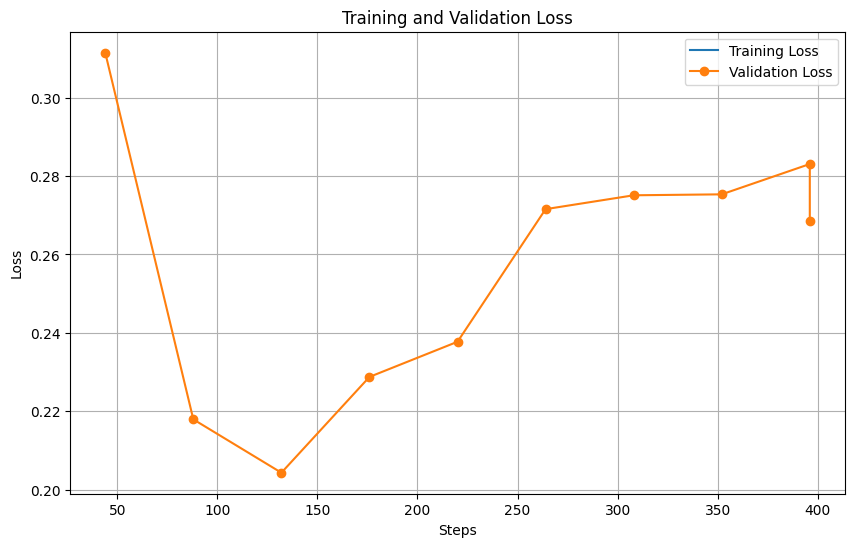

In [30]:
# 9. Código para procesar todo el dataset original
def process_full_dataset(input_file, output_file, model, tokenizer, tag2id, id2tag):
    """
    Procesa todo el dataset original y genera un nuevo archivo con productos y atributos detectados.
    
    Args:
        input_file (str): Ruta al archivo Excel original
        output_file (str): Ruta donde guardar el archivo procesado
        model: Modelo MobileBERT entrenado
        tokenizer: Tokenizador MobileBERT
        tag2id: Mapeo de etiquetas a IDs
        id2tag: Mapeo de IDs a etiquetas
    """
    print(f"Procesando archivo completo: {input_file}")
    
    # Cargar el dataset original
    df_original = pd.read_excel(input_file)
    
    # Columnas para resultados
    df_original['detected_products'] = ""
    df_original['detected_attributes'] = ""
    
    # Procesar cada fila
    for i, row in tqdm(df_original.iterrows(), total=len(df_original), desc="Procesando transcripciones"):
        try:
            text = row['transcription']
            if pd.isna(text) or text.strip() == "":
                continue
                
            # Predecir entidades
            results = predict_entities(text, model, tokenizer, tag2id, id2tag)
            
            # Guardar resultados
            df_original.at[i, 'detected_products'] = ", ".join(results['products'])
            df_original.at[i, 'detected_attributes'] = ", ".join(results['attributes'])
            
        except Exception as e:
            print(f"Error procesando fila {i}: {str(e)}")
    
    # Guardar el dataset procesado
    df_original.to_excel(output_file, index=False)
    print(f"Dataset procesado guardado en: {output_file}")

# Ejemplo de uso para procesar todo el dataset
# Descomenta estas líneas cuando quieras procesar todo el archivo
full_dataset_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\results_brand_detection.xlsx"
output_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\products_attributes\results\sentences_transcriptions_processed.xlsx"
process_full_dataset(full_dataset_path, output_path, model, tokenizer, tag2id, id2tag)


# 10. Visualización de pérdida durante entrenamiento
train_history = trainer.state.log_history

# Extraer valores de pérdida
train_losses = [x.get('loss') for x in train_history if 'loss' in x and 'eval_loss' not in x]
train_steps = [x.get('step') for x in train_history if 'loss' in x and 'eval_loss' not in x]
eval_losses = [x.get('eval_loss') for x in train_history if 'eval_loss' in x]
eval_steps = [x.get('step') for x in train_history if 'eval_loss' in x]

# Graficar pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curves.png'))
plt.show()

In [31]:
# Siguiente paso tengo que coger el archivo este que me devuelve y agrupar las caracteristicas por menciones cercanas. 
# Poner también que si no detecta marca lo deje en blanco no q no ponga no se ha detectado, pq luego el MBA se lia.
import pandas as pd
import pandas as pd
import numpy as np
import os

file_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\products_attributes\results\sentences_transcriptions_processed.xlsx"
df = pd.read_excel(file_path)

df['brand_detected'] = df['brand_detected'].replace("No se detectó marca", "")

# Agrupar el DataFrame por URL
grouped = df.groupby('id_urlvideo')

# Nuevo DataFrame para almacenar resultados
result_df = df.copy()

# Para cada grupo de URL
for url, group in grouped:
    # Identificar filas con marca
    marca_indices = group[group['brand_detected'] != ""].index.tolist()
    
    if not marca_indices:  # Si no hay marcas en este grupo, continuar
        continue
    
    # Para cada fila en el grupo
    for idx in group.index:
        # Si la fila ya tiene marca, mantener sus productos y atributos
        if idx in marca_indices:
            continue
        
        # Encontrar el índice con marca más cercano
        closest_marca_idx = min(marca_indices, key=lambda x: abs(x - idx))
        
        # Productos detectados en la fila actual
        productos = group.loc[idx, 'detected_products']
        atributos = group.loc[idx, 'detected_attributes']
        
        # Si hay productos, añadirlos a la fila con marca más cercana
        if productos and not pd.isna(productos):
            # Obtener productos actuales de la fila con marca
            current_products = result_df.loc[closest_marca_idx, 'detected_products']
            if pd.isna(current_products) or current_products == "":
                result_df.loc[closest_marca_idx, 'detected_products'] = productos
            else:
                # Combinar evitando duplicados
                all_products = set(current_products.split(", ") + productos.split(", "))
                all_products = {p for p in all_products if p}  # Eliminar cadenas vacías
                result_df.loc[closest_marca_idx, 'detected_products'] = ", ".join(all_products)
        
        # Si hay atributos, añadirlos a la fila con marca más cercana
        if atributos and not pd.isna(atributos):
            # Obtener atributos actuales de la fila con marca
            current_attrs = result_df.loc[closest_marca_idx, 'detected_attributes']
            if pd.isna(current_attrs) or current_attrs == "":
                result_df.loc[closest_marca_idx, 'detected_attributes'] = atributos
            else:
                # Combinar evitando duplicados
                all_attrs = set(current_attrs.split(", ") + atributos.split(", "))
                all_attrs = {a for a in all_attrs if a}  # Eliminar cadenas vacías
                result_df.loc[closest_marca_idx, 'detected_attributes'] = ", ".join(all_attrs)
        
        # Limpiar la fila original (sin marca)
        result_df.loc[idx, 'detected_products'] = ""
        result_df.loc[idx, 'detected_attributes'] = ""
result_df = result_df[result_df['brand_detected'] != ""]
# Guardar el resultado
output_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\results_detections.xlsx"
result_df.to_excel(output_path, index=False)
print(f"Archivo guardado en: {output_path}")
result_df

Archivo guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\results_detections.xlsx


,id_urlvideo,transcription,brand_detected,match_text,sentiment_score,sentiment_label,context_text,detected_products,detected_attributes
15,https://www.tiktok.com/@aliciarev/video/728025...,"I use the Genifit from Lancome, which costs on...",Lancôme,"e Genifit from Lancome, which costs o",0.0000,neutral,"It leaves your skin glowing, not the next thin...","calming clean, eye con, tone, clean, cleansing...","worth, expensive"
17,https://www.tiktok.com/@aliciarev/video/728025...,I also use Lancome's Genifit serum.,Lancôme,I also use Lancome's Genifit seru,0.8674,positive,"I use the Genifit from Lancome, which costs on...",gen,NaN
25,https://www.tiktok.com/@aliciarev/video/728025...,"It's Eve Pound, the blue one from Drunk Elephant.",Drunk Elephant,blue one from Drunk Elephant.,0.7783,positive,And since I like to use really thick things at...,"moist, cream",moist
30,https://www.tiktok.com/@aliciarev/video/728025...,"Then I put on the eyebrow serum, which is Bene...",Benefit Cosmetics,"erum, which is Benefit's Huba Brow.",0.7189,positive,They help me so that the nuclear white isn't s...,"eyebrow serum, white",NaN
34,https://www.tiktok.com/@aliciarev/video/728025...,"And finally, for the lips, the Laneige lip sle...",Laneige,"the lips, the Laneige lip sleeping m",0.8805,positive,"It costs 71 euros. Well, it works really well....",sleeping mask,"chocolate, generous"
...,...,...,...,...,...,...,...,...,...
6769,https://www.tiktok.com/@aleshadows_/video/7454...,The one from the Kerr line from Sephora Collec...,SEPHORA COLLECTION,Kerr line from Sephora Collection.,0.8100,positive,Let's go with the cream contour or bronzer. Of...,bronze,"low cost, amazing"
6771,https://www.tiktok.com/@aleshadows_/video/7454...,"And again Make Up by Mario, but this time this...",Make Up By Mario,"And again Make Up by Mario, but this time",0.9725,positive,The one from the Kerr line from Sephora Collec...,"highlight, bal","gorgeous, shade"
6776,https://www.tiktok.com/@aleshadows_/video/7454...,A classic every year is the Pingasem from Char...,Charlotte Tilbury,Pingasem from Charlotte Tilbury.,0.8519,positive,I have talked about it a thousand times but it...,NaN,"classic, perfect"
6777,https://www.tiktok.com/@aleshadows_/video/7454...,The stick blush from Make Up by Mario in the s...,Make Up By Mario,ick blush from Make Up by Mario in the shade P,0.9052,positive,"And last but not least in this video, liquid c...","stick blush, bronze","shade, blush"


In [34]:
import pandas as pd
import pandas as pd
import numpy as np
from difflib import get_close_matches
import re

def extract_unique_terms(dataframe, column_name):
    """Función que saca los valores unicos de columnas con listas separadas por coma."""
    filtered_df = dataframe[~dataframe[column_name].isna()]
    unique_values = set()
    for value in filtered_df[column_name]:
        if isinstance(value, str) and value.strip():
            items = [item.strip() for item in value.split(',')]
            unique_values.update([item for item in items if item])
    
    unique_list = sorted(list(unique_values))
    return unique_list

unique_products = extract_unique_terms(result_df, 'detected_products')
unique_attributes = extract_unique_terms(result_df, 'detected_attributes')

# Cargar el archivo con las categorías originales
categories_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\data_bert\labeled_sentences.xlsx"
categories_df = pd.read_excel(categories_path)
product_column = categories_df.columns[2]  # columna de productos_detected
attribute_column = categories_df.columns[3] # columna attributes_detected
# Categorías únicas de los datos etiquetados
def extract_product_categories(text):
    if not isinstance(text, str) or not text.strip():
        return []
    
    # Dividir por comas primero
    items = [item.strip() for item in text.split(',')]
    products = []
    
    for item in items:
        # Extraer el nombre del producto (ignorando la categoría entre paréntesis)
        match = re.match(r'^(.*?)\s*\([^)]*\)$', item.strip())
        if match:
            product = match.group(1).strip().lower()
            if product:
                products.append(product)
        else:
            # Si no hay paréntesis, usar el elemento completo
            product = item.strip().lower()
            if product:
                products.append(product)
    
    return products

def extract_attribute_categories(text):
    """Extraer Productos y Atributos Únicos sin parentesis y sin comas."""
    if not isinstance(text, str) or not text.strip():
        return []
    
    # Dividir por comas y limpiar
    attributes = [attr.strip().lower() for attr in text.split(',')]
    return [attr for attr in attributes if attr]

all_product_categories = []
for text in categories_df[product_column].dropna():
    all_product_categories.extend(extract_product_categories(text))

all_attribute_categories = []
for text in categories_df[attribute_column].dropna():
    all_attribute_categories.extend(extract_attribute_categories(text))

unique_product_categories = sorted(set(all_product_categories))
unique_attribute_categories = sorted(set(all_attribute_categories))

def refined_assign_to_category(term, categories, similar_terms=None, min_term_length=3):
    """
    Función refinada para asignar términos a categorías, conservando más nombres de productos.
    
    Args:
        term (str): Término a asignar
        categories (list): Lista de categorías disponibles
        similar_terms (dict, optional): Diccionario de términos similares o correcciones manuales
        min_term_length (int): Longitud mínima para considerar un término como válido
    
    Returns:
        str: Categoría asignada
    """
    # Limpiar el término
    term_lower = term.lower().strip()
    
    # Verificar correcciones manuales primero
    if similar_terms and term_lower in similar_terms:
        return similar_terms[term_lower]
    
    # Intentar coincidencia exacta
    if term_lower in categories:
        return term_lower
    
    # Lista de términos que definitivamente no son productos/atributos
    definite_non_products = ['-', '201', '+', '&', '/', '•']
    if term_lower in definite_non_products:
        return "other"
    
    # Casos especiales con correcciones manuales
    if term_lower == "beauty blend" or term_lower == "beauty blender":
        return "beauty blender"
    
    # Para términos como "backstage", "acid", etc. que podrían ser nombres de productos
    # Si tienen una longitud razonable, los mantenemos como están
    if len(term_lower) >= min_term_length and not term_lower.isdigit():
        # Verificar si es parte de una categoría conocida
        for category in categories:
            pattern = r'\b' + re.escape(term_lower) + r'\b'
            if re.search(pattern, category):
                return category
        
        # Si no es parte de una categoría pero parece un nombre válido, lo dejamos
        return term_lower
    
    # Buscar coincidencias parciales priorizando términos más largos
    sorted_categories = sorted(categories, key=len, reverse=True)
    
    for category in sorted_categories:
        # Comprobar si la categoría es una palabra completa dentro del término
        pattern = r'\b' + re.escape(category) + r'\b'
        if re.search(pattern, term_lower):
            return category
    
    # Si el término es corto pero significativo (como "bb" en "bb cream")
    if term_lower in ["bb", "cc", "dd", "spf"] and len(term_lower) == 2:
        return term_lower
    
    # Usar similitud de cadena con umbral más bajo para términos que parecen nombres
    matches = get_close_matches(term_lower, categories, n=1, cutoff=0.7)
    if matches:
        return matches[0]
    
    # Si parece un nombre de producto válido, lo conservamos
    if len(term_lower) >= min_term_length and not term_lower.isdigit() and term_lower not in ["the", "and", "for", "with"]:
        return term_lower
    
    # Si nada más funciona, devolver "other"
    return "other"

# Definir correcciones manuales específicas
manual_corrections_products = {
    "beauty blend": "beauty blender",
    "benefit mascara": "mascara",
    "barrier cream": "cream",
    "backstage": "backstage palette", 
    "acid": "acid treatment",
    "bal": "balm",
    "vase":"base",
    "tan": "tanned",
    "ta": "tanned",
    "skin pri":"skin primer",
    "settings break":"setting spray",
    "pillow tail": "pillow talk",
    "pillow": "pillow talk",
    "pen": "pencil",
    "orgasm":"pinkgasm",
    "nose con":"contour",
    "conceal": "concealer",
    "condition": "concealer",
    "con":"contour",
    "nose con":"contour",
    "pen": "pencil",
}

manual_corrections_attributes = {
    "allergy tested": "allergy tested",
    "amazing": "amazing",
    "good": "good",
    "four shades":"shade",
    "sham":"shine",
    "shadows":"shadow",
    "settings break":"setting spray",
    "pillow tail": "pillow talk",
    "pillow": "pillow talk",
    "orgasm":"pinkgasm",

}

# Aplicar el mapeo refinado
refined_product_mappings = {}
for product in unique_products:
    refined_product_mappings[product] = refined_assign_to_category(
        product, 
        unique_product_categories, 
        manual_corrections_products
    )

refined_attribute_mappings = {}
for attribute in unique_attributes:
    refined_attribute_mappings[attribute] = refined_assign_to_category(
        attribute, 
        unique_attribute_categories, 
        manual_corrections_attributes
    )
# Aplicar los mapeos refinados al DataFrame original
def apply_mappings_to_dataframe(df, product_mappings, attribute_mappings):
    """
    Aplica los mapeos de corrección a las columnas de productos y atributos del DataFrame.
    
    Args:
        df: DataFrame original
        product_mappings: Diccionario de mapeos para productos
        attribute_mappings: Diccionario de mapeos para atributos
    
    Returns:
        DataFrame con productos y atributos corregidos
    """
    # Crear una copia del DataFrame para no modificar el original
    corrected_df = df.copy()
    
    # Función para aplicar mapeos a una lista de términos separados por comas
    def apply_mapping_to_list(value, mappings):
        if not isinstance(value, str) or not value.strip():
            return value
        
        # Dividir por comas
        items = [item.strip() for item in value.split(',')]
        
        # Aplicar mapeo a cada término
        corrected_items = []
        for item in items:
            if item:
                # Si el ítem está en nuestro mapeo y no es "other", usarlo
                mapped_item = mappings.get(item.lower(), item)
                if mapped_item != "other":
                    corrected_items.append(mapped_item)
                # Si no está en nuestro mapeo, mantener el original
                else:
                    if len(item) >= 3:  # Mantener solo términos significativos
                        corrected_items.append(item)
        
        # Unir los términos corregidos
        return ", ".join(corrected_items) if corrected_items else ""
    
    # Aplicar correcciones a la columna de productos
    if 'detected_products' in corrected_df.columns:
        corrected_df['detected_products'] = corrected_df['detected_products'].apply(
            lambda x: apply_mapping_to_list(x, product_mappings)
        )
    
    # Aplicar correcciones a la columna de atributos
    if 'detected_attributes' in corrected_df.columns:
        corrected_df['detected_attributes'] = corrected_df['detected_attributes'].apply(
            lambda x: apply_mapping_to_list(x, attribute_mappings)
        )
    
    return corrected_df

# Aplicar las correcciones
corrected_result_df = apply_mappings_to_dataframe(result_df, refined_product_mappings, refined_attribute_mappings)

# Guardar el DataFrame corregido en un nuevo Excel
output_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\corrected_results_detections.xlsx"
corrected_result_df.to_excel(output_path, index=False)
print(f"DataFrame corregido guardado en: {output_path}")

# Verificar algunos ejemplos de correcciones
print("\nEjemplos de correcciones aplicadas:")
if len(result_df) > 0:
    sample_indices = min(5, len(result_df))
    for i in range(sample_indices):
        original_products = result_df.iloc[i]['detected_products'] if 'detected_products' in result_df.columns else ''
        corrected_products = corrected_result_df.iloc[i]['detected_products'] if 'detected_products' in corrected_result_df.columns else ''
        
        original_attributes = result_df.iloc[i]['detected_attributes'] if 'detected_attributes' in result_df.columns else ''
        corrected_attributes = corrected_result_df.iloc[i]['detected_attributes'] if 'detected_attributes' in corrected_result_df.columns else ''
        
        print(f"\nEjemplo {i+1}:")
        print(f"  Productos originales: {original_products}")
        print(f"  Productos corregidos: {corrected_products}")
        print(f"  Atributos originales: {original_attributes}")
        print(f"  Atributos corregidos: {corrected_attributes}")


DataFrame corregido guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\corrected_results_detections.xlsx

Ejemplos de correcciones aplicadas:

Ejemplo 1:
  Productos originales: calming clean, eye con, tone, clean, cleansing oil
  Productos corregidos: calming clean, eye con, tone, clean, cleansing oil
  Atributos originales: worth, expensive
  Atributos corregidos: worth, expensive

Ejemplo 2:
  Productos originales: gen
  Productos corregidos: gen
  Atributos originales: nan
  Atributos corregidos: nan

Ejemplo 3:
  Productos originales: moist, cream
  Productos corregidos: moist, cream
  Atributos originales: moist
  Atributos corregidos: moist

Ejemplo 4:
  Productos originales: eyebrow serum, white
  Productos corregidos: eyebrow serum, white
  Atributos originales: nan
  Atributos corregidos: nan

Ejemplo 5:
  Productos originales: sleeping mask
  Productos corregidos: sleeping mask
  Atributos originales: chocolate, generous
  Atributos co

In [49]:
import pandas as pd
import numpy as np
import re
import os
from collections import Counter

# Configurar rutas
input_file = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\data\clean_data\sephora_website_cleaned.csv"
output_dir = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\data for kmeans"

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Leer el archivo CSV de Sephora
print(f"Leyendo archivo CSV: {input_file}")
sephora_df = pd.read_csv(input_file)

# Definir términos específicos que caracterizan productos cosméticos (convertido a conjunto)
cosmetic_specific_terms = {
    # Tipo de producto
    'foundation', 'concealer', 'powder', 'blush', 'bronzer', 'highlighter', 
    'eyeshadow', 'eyeliner', 'mascara', 'lipstick', 'lip gloss', 'lip balm', 
    'primer', 'setting spray', 'face mask', 'moisturizer', 'serum', 'toner', 
    'cleanser', 'eye cream', 'sunscreen', 'bb cream', 'cc cream', 'brow pencil',
    'palette', 'contour', 'illuminator', 'sponge', 'beauty blender',
    
    # Texturas y acabados
    'matte', 'dewy', 'glowy', 'radiant', 'luminous', 'shimmery', 'glossy', 'satin',
    'metallic', 'glitter', 'creamy', 'whipped', 'gel', 'liquid', 'cream',
    'mousse', 'balm', 'oil', 'stick', 'cushion', 'lightweight', 'full-coverage',
    
    # Ingredientes clave
    'retinol', 'vitamin c', 'hyaluronic acid', 'peptides', 'niacinamide', 'aha',
    'bha', 'salicylic acid', 'glycolic acid', 'lactic acid', 'ceramides', 'spf',
    'antioxidants', 'collagen', 'aloe', 'shea butter', 'tea tree', 'squalane',
    'bakuchiol', 'vitamin e', 'zinc', 'caffeine', 'centella', 'propolis',
    
    # Características y beneficios
    'vegan', 'cruelty-free', 'clean', 'organic', 'natural', 'dermatologist-tested',
    'hypoallergenic', 'non-comedogenic', 'paraben-free', 'sulfate-free', 'silicone-free',
    'fragrance-free', 'alcohol-free', 'gluten-free', 'oil-free', 'waterproof',
    'longwear', 'transfer-proof', 'buildable', 'hydrating', 'moisturizing', 'brightening',
    'anti-aging', 'firming', 'plumping', 'exfoliating', 'soothing', 'calming',
    
    # Estilo y mercado
    'luxury', 'premium', 'affordable', 'professional', 'korean', 'japanese', 'french',
    'k-beauty', 'j-beauty', 'inclusive', 'sustainable', 'refillable', 'travel-sized',
    'limited-edition', 'customizable', 'unisex', 'cruelty free'
}

# Frases a excluir del formato de descripción de Sephora (convertido a conjunto)
sephora_format_phrases = {
    'what it is', 'what else you need to know', 'what else you need', 'what else', 
    'you need to know', 'you need to', 'need to know', 'need to', 'to know',
    'it is', 'it is a', 'is a', 'this is', 'this is a', 'that is', 'that is a',
    'else you need', 'else you', 'with a', 'without a', 'of the', 'in the', 'on the',
    'for the', 'at the', 'by the', 'from the', 'to the', 'with the', 'and the',
    'highlighted ingredients', 'ingredient callouts', 'formulation type', 'coverage',
    'finish', 'benefits', 'formulation', 'why we like it', 'how to use', 'what you get',
    'key ingredients', 'key benefits', 'suggested usage', 'free of', 'made with',
    'contains', 'includes', 'helps', 'helps to', 'designed to', 'works to',
    'makes', 'gives', 'provides', 'delivers', 'offers', 'features', 'perfect for',
    'ideal for', 'great for', 'suitable for', 'specially formulated',
    'clinically proven', 'dermatologist tested', 'ophthalmologist tested'
}

# Palabras genéricas a excluir (convertido a conjunto)
generic_words = {
    'it', 'is', 'it is', 'this', 'this is', 'that', 'that is', 'the', 'and', 'are', 'these', 
    'those', 'with', 'without', 'synthetic', 'else you need', 'else you', 'you need to', 
    'need to know', 'need to', 'to know', 'what it is', 'is a', 'what else you', 'what else', 
    'help', 'contains', 'it is a', 'from', 'into', 'during', 'before', 'after', 'above', 
    'below', 'between', 'among', 'throughout', 'through', 'over', 'under', 'within', 'along', 
    'across', 'around', 'about', 'against', 'beyond', 'near', 'same', 'different', 'various',
    'several', 'few', 'many', 'much', 'some', 'any', 'all', 'every', 'each', 'either',
    'neither', 'both', 'such', 'like', 'unlike', 'similar', 'other', 'another',
    'than', 'then', 'now', 'later', 'earlier', 'soon', 'already', 'still', 'yet',
    'once', 'twice', 'again', 'ever', 'never', 'always', 'often', 'seldom', 'usually',
    'generally', 'sometimes', 'rarely', 'frequently', 'occasionally', 'normally',
    'commonly', 'naturally', 'especially', 'particularly', 'specifically', 'exactly',
    'precisely', 'approximately', 'roughly', 'nearly', 'almost', 'virtually', 'practically',
    'essentially', 'basically', 'fundamentally', 'primarily', 'mainly', 'mostly',
    'largely', 'chiefly', 'principally', 'predominantly', 'significantly',
    'notably', 'markedly', 'considerably', 'substantially', 'extensively', 'thoroughly',
    'completely', 'entirely', 'totally', 'wholly', 'fully', 'partly', 'partially',
    'somewhat', 'slightly', 'relatively', 'comparatively', 'rather', 'quite', 'extremely',
    'very', 'too', 'enough', 'sufficiently', 'adequately', 'properly', 'correctly',
    'accordingly', 'consequently', 'therefore', 'thus', 'hence', 'so', 'otherwise',
    'nonetheless', 'nevertheless', 'however', 'although', 'though', 'even', 'just',
    'only', 'merely', 'simply', 'really', 'actually', 'fact', 'indeed', 'certainly',
    'definitely', 'absolutely', 'undoubtedly', 'surely', 'clearly', 'obviously',
    'apparently', 'seemingly', 'possibly', 'perhaps', 'maybe', 'probably',
    'likely', 'unlikely', 'doubtfully', 'supposedly', 'allegedly', 'reportedly',
    'furthermore', 'moreover', 'additionally', 'also', 'besides',
    'likewise', 'similarly', 'instead', 'alternatively', 'conversely',
    'whereas', 'while', 'because', 'since', 'due', 'owing', 'result',
    'subsequently', 'next', 'last', 'finally', 'ultimately', 'eventually', 
    'steadily', 'continuously', 'constantly', 'persistently', 'consistently', 'regularly',
    'periodically', 'intermittently', 'sporadically', 'randomly', 'suddenly', 'abruptly',
    'immediately', 'instantly', 'quickly', 'rapidly', 'swiftly', 'promptly', 'hastily',
    'speedily', 'slowly', 'deliberately', 'purposefully', 'intentionally',
    'knowingly', 'unwittingly', 'accidentally', 'mistakenly', 'erroneously',
    'incorrectly', 'rightly', 'appropriately', 'suitably',
    'satisfactorily', 'effectively', 'efficiently', 'successfully', 'poorly', 'badly',
    'terribly', 'horribly', 'awfully', 'dreadfully', 'wonderfully', 'beautifully',
    'nicely', 'pleasantly', 'delightfully', 'fortunately', 'unfortunately', 'happily',
    'sadly', 'regrettably', 'hopefully', 'presumably',
    'evidently', 'unquestionably', 'indisputably', 'indubitably', 'no', 'not', 'none', 
    'nobody', 'nothing', 'nowhere', 'nor', 'one', 'everything', 'everyone', 'everybody',
    'everywhere', 'both', 'someone', 'somebody', 'something', 'somewhere', 'sometime', 
    'anyone', 'anybody', 'anything', 'anywhere', 'anytime',
    
    # Palabras específicas del dominio que queremos excluir
    'is', 'application', 'collection', 'bristles', 'know', 'skin', 'brushes', "what","liquid", 'lips', 'brow', 'finish', 'brows', 'formula', 'color',
    'reflects', 'shades', 'parabens',
    'brand', 'product', 'products', 'item', 'items', 'use', 'using', 'used',
    'look', 'looks', 'looking', 'apply', 'applied', 'applying', 'wear', 'wearing',
    'choose', 'time', 'times', 'day', 'days', 'week', 'weeks', 'month', 'months',
    'year', 'years', 'size', 'small', 'medium', 'large', 'mini', 'full',
    'new', 'old', 'fresh', 'set', 'sets', 'kit', 'kits', 'bundle', 'feature',
    'features', 'benefit', 'benefits', 'include', 'includes', 'included',
    'contain', 'contains', 'contained', 'create', 'creates', 'created',
    'provide', 'provides', 'provided', 'offer', 'offers', 'offered',
    'exclusive', 'recommend', 'recommended', 'favorite', 'favorites',
    'best', 'better', 'good', 'great', 'excellent', 'amazing', 'perfect',
    'love', 'loved', 'loves', 'loving', 'like', 'liked', 'likes', 'liking',
    'works', 'worked', 'working', 'want', 'wanted', 'wanting', 'wants',
    'designed', 'designed for', 'specially', 'special', 'specific', 'specifically',
    'designed to', 'made to', 'formulated', 'formulated to', 'specially formulated'
}

def extract_meaningful_terms(text, target_terms=cosmetic_specific_terms, 
                             excluded_phrases=sephora_format_phrases,
                             generic_stopwords=generic_words):
    """
    Extrae términos significativos y representativos específicos del sector cosmético,
    evitando frases del formato de descripción de Sephora y palabras genéricas.
    """
    if pd.isna(text) or not isinstance(text, str):
        return []
    
    # Convertir a minúsculas y limpieza inicial
    text = text.lower()
    text = re.sub(r'[^\w\s-]', ' ', text)  # Reemplazar puntuación conservando guiones
    text = re.sub(r'\s+', ' ', text)       # Normalizar espacios
    
    # Preprocesamiento: eliminar frases del formato de descripciones de Sephora
    processed_text = ' ' + text + ' '  # Añadir espacios para detectar palabras completas
    for phrase in excluded_phrases:
        processed_text = processed_text.replace(' ' + phrase + ' ', ' ')
    
    # Volver a normalizar espacios después de eliminar frases
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()
    
    # Buscar términos específicos de cosmética en el texto procesado
    found_terms = []
    
    # Primero buscar términos específicos de cosmética (prioridad)
    for term in target_terms:
        # Verificar si el término aparece como palabra completa
        pattern = r'\b' + re.escape(term) + r'\b'
        if re.search(pattern, processed_text):
            # Verificar que ninguna palabra del término esté en la lista de stopwords
            term_words = term.split()
            if not any(word in generic_stopwords for word in term_words):
                found_terms.append(term)
    
    # Buscar palabras individuales que podrían ser relevantes
    individual_words = set(re.findall(r'\b[a-z]{3,}\b', processed_text))
    
    # Filtrar palabras individuales contra stopwords
    for word in individual_words:
        if (word not in generic_stopwords and 
            word not in found_terms and 
            not any(word in term.split() for term in found_terms)):
            found_terms.append(word)
    
    # Contar frecuencias de los términos encontrados
    term_counts = Counter(found_terms)
    
    # Filtro final: verificar una vez más que ningún término contenga palabras en generic_stopwords
    filtered_terms = Counter()
    for term, count in term_counts.items():
        term_words = term.split()
        if not any(word in generic_stopwords for word in term_words):
            filtered_terms[term] = count
    
    return filtered_terms

# Preparar el dataframe
print("Procesando datos y extrayendo términos significativos por marca...")

# Combinar columnas de descripción
description_columns = [col for col in ['description', 'What it is', 'Finish', 'What Else You Need to Know'] 
                     if col in sephora_df.columns]

# Crear una columna combinada de descripciones
sephora_df['combined_description'] = sephora_df[description_columns].apply(
    lambda row: ' '.join([str(cell) for cell in row if not pd.isna(cell)]), axis=1
)

# Agrupar por marca
brand_groups = sephora_df.groupby('brand')

# Lista para almacenar los resultados
brand_data = []

# Procesar cada marca
for brand, group in brand_groups:
    # Combinar todas las descripciones de esta marca
    all_descriptions = ' '.join(group['combined_description'].tolist())
    
    # Extraer términos significativos
    term_counts = extract_meaningful_terms(all_descriptions)
    
    # Obtener los 30 términos más frecuentes
    top_terms = [term for term, count in term_counts.most_common(30)]
    
    # Calcular el precio promedio de los productos de esta marca
    avg_price = group['current_price'].astype(float).mean() if 'current_price' in group.columns else np.nan
    
    # Contar número de productos de esta marca
    num_products = len(group)
    
    # Guardar datos de esta marca
    brand_data.append({
        'brand': brand,
        'representative_terms': ', '.join(top_terms),
        'avg_price': avg_price,
        'num_products': num_products
    })

# Crear dataframe con la información por marca
brand_df = pd.DataFrame(brand_data)

# Ordenar por número de productos (marcas con más productos primero)
brand_df = brand_df.sort_values('num_products', ascending=False)

# Guardar en Excel
output_file = os.path.join(output_dir, 'brand_meaningful_terms_forkmeans.xlsx')
brand_df.to_excel(output_file, index=False)

print(f"Archivo guardado en: {output_file}")
print(f"Total de marcas procesadas: {len(brand_df)}")

# Mostrar algunos ejemplos
print("\nEjemplos de las primeras marcas procesadas:")
for i, row in brand_df.head(3).iterrows():
    print(f"\nMarca: {row['brand']}")
    print(f"Promedio de precio: ${row['avg_price']:.2f}")
    print(f"Número de productos: {row['num_products']}")
    print(f"Términos significativos: {row['representative_terms']}")

Leyendo archivo CSV: C:\Users\sandr\Documents\scrp_tiktok_tfg\data\clean_data\sephora_website_cleaned.csv
Procesando datos y extrayendo términos significativos por marca...
Archivo guardado en: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\data for kmeans\brand_meaningful_terms_forkmeans.xlsx
Total de marcas procesadas: 147

Ejemplos de las primeras marcas procesadas:

Marca: SEPHORA COLLECTION
Promedio de precio: $18.91
Número de productos: 142
Términos significativos: vitamin e, caffeine, natural, concealer, limited-edition, brightening, mascara, primer, professional, tea tree, cream, full-coverage, hypoallergenic, powder, glossy, lip gloss, ceramides, niacinamide, plumping, metallic, alcohol-free, contour, lipstick, balm, highlighter, hyaluronic acid, vitamin c, bronzer, oil, lip balm

Marca: Anastasia Beverly Hills
Promedio de precio: $25.18
Número de productos: 83
Términos significativos: vitamin e, peptides, premium, natural, concealer, dermatologist-tested, mascara, p